# Aerial Cactus Detection

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from time import time
from winsound import Beep
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,\
    Conv2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
os.chdir('C:/Users/Nicolas/Documents/Data/aerial-cactus-identification')

#### Importing the data

In [2]:
df = pd.read_csv('train.csv')

#### Inspecting the data

Head

In [3]:
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
str_categories = ['No Cactus', 'Has Cactus']

Train files

In [5]:
files = glob('train/*.jpg')

In [6]:
print(f'We have {len(files):,} pictures.')

We have 17,500 pictures.


Class imbalance

In [7]:
print(f'{int(df["has_cactus"].sum()/len(files)*100)}% of images have cacti.')

75% of images have cacti.


#### Visualizing Images

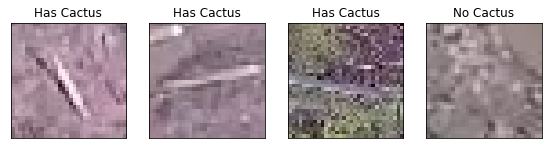

In [35]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(len(files))
    img = plt.imread(files[rand])
    ax = plt.imshow(img)
    plt.title('{}'.format(str_categories[df['has_cactus'][rand]]))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

#### Making an array of images

In [9]:
image_array = []
for image in files:
    image_array.append(plt.imread(image))

In [10]:
X = np.array(image_array)

In [11]:
image_array = None # clear cache

In [12]:
X.shape

(17500, 32, 32, 3)

In [13]:
print(f'We have {X.shape[0]:,} images of width {X.shape[1]}, of height {X.shape[2]},' \
      f' and with {X.shape[3]} channels.')

We have 17,500 images of width 32, of height 32, and with 3 channels.


#### Making an array of targets

In [14]:
y = to_categorical(df['has_cactus'].values, 2)

In [15]:
y.dtype

dtype('float32')

In [16]:
# y = y.reshape(-1, 1, 1, 2)

#### Train/test split

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

#### Simple CNN

In [18]:
model = Sequential([
    ZeroPadding2D((1,1),input_shape=(32, 32, 3)),
    Conv2D(64, 3, 3, activation='relu'),
    ZeroPadding2D((1,1)),
    Conv2D(64, 3, 3, activation='relu'),
    MaxPooling2D((2,2), strides=(2,2)),

    ZeroPadding2D((1,1)),
    Conv2D(128, 3, 3, activation='relu'),
    ZeroPadding2D((1,1)),
    Conv2D(128, 3, 3, activation='relu'),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    
    Dense(2, activation='softmax')
    ])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 34, 34, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 11, 11, 64)        1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 64)          0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         73856     
__________

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [21]:
callbacks = [
    EarlyStopping(monitor='val_acc', patience=5)
            ]

In [22]:
hist = model.fit(xtrain, ytrain,
                 epochs=50, 
                 batch_size=16,
                 validation_data=[xtest, ytest],
                 callbacks=callbacks)

Train on 13125 samples, validate on 4375 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
13125/13125 [==============================] - 26s 2ms/sample - loss: 0.2707 - acc: 0.8994 - val_loss: 0.4698 - val_acc: 0.7968
Epoch 2/50
13125/13125 [==============================] - 23s 2ms/sample - loss: 0.1783 - acc: 0.9335 - val_loss: 0.1756 - val_acc: 0.9351
Epoch 3/50
13125/13125 [==============================] - 23s 2ms/sample - loss: 0.1785 - acc: 0.9336 - val_loss: 0.1751 - val_acc: 0.9408
Epoch 4/50
13125/13125 [==============================] - 23s 2ms/sample - loss: 0.1718 - acc: 0.9397 - val_loss: 0.1714 - val_acc: 0.9305
Epoch 5/50
13125/13125 [==============================] - 23s 2ms/sample - loss: 0.1404 - acc: 0.9478 - val_loss: 0.1374 - val_acc: 0.9440
Epoch 6/50
13125/13125 [==============================] - 23s 2ms/sample - loss: 0.1286 - acc: 0.9518 - val_loss: 0.1105 - val_acc: 0.9568
Epoch 7/50
13125/13125 [==============================] - 23s 2ms/sam

In [25]:
pd.DataFrame(hist.history).tail()

,loss,acc,val_loss,val_acc
7,0.107265,0.961371,0.122310,0.957486
8,0.117678,0.956800,0.113452,0.957257
9,0.112869,0.956952,0.166268,0.937600
10,0.127935,0.952762,0.109138,0.959771
11,0.109868,0.960152,0.135981,0.961143


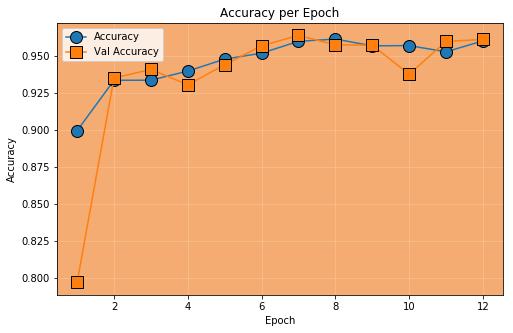

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(np.arange(1, len(hist.history['acc'])+1), hist.history['acc'], marker='o', mec='k', ms=12)
plt.plot(np.arange(1, len(hist.history['acc'])+1), hist.history['val_acc'], marker='s', mec='k', ms=12)
ax.set_facecolor('#F5AC72')
plt.grid(True, alpha=.2, color='white')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Val Accuracy'])